In [1]:
print("Hello world")

Hello world


# Read the Data         
---

# Libraries         
---

In [2]:
# 기본
import pandas as pd
import numpy as np 
import os
import warnings
warnings.filterwarnings("ignore")

# 시각화 
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns

# 모델
from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV)

from sklearn.tree import (DecisionTreeClassifier, 
                          DecisionTreeRegressor)

from sklearn.ensemble import (RandomForestClassifier, 
                              RandomForestRegressor)

from sklearn.svm import SVC

from xgboost import XGBClassifier

# sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# report
from sklearn import metrics
# matrix = metrics.confusion_matrix(y_test, y_pred)
from sklearn.metrics import classification_report, roc_curve, auc

#encoder, scaler
from sklearn.preprocessing import (LabelEncoder, 
                                   OneHotEncoder, 
                                   StandardScaler,
                                   MinMaxScaler)

# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# test
import statsmodels.api as sm 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(context = 'talk',  
              style = 'darkgrid',  
              font = 'Malgun Gothic', 
              font_scale = 1.2,         
              rc = custom_params) 

In [4]:
cur_dir = os.getcwd()

for root, dirs, files in os.walk(cur_dir):
    if '.git' not in root:
        print(root, files)

c:\Users\jaekyung\Documents\ML ['.gitignore', '1company_rating.ipynb', '1Heart_Disease.ipynb', '1Heart_Disease_re.ipynb', '1Insurance_charge.ipynb', '1project_pre.ipynb', 'graph.txt', 'Libraries.ipynb', 'modeling checklist.ipynb', 'Mv_txt.ipynb', 'pre.txt', 'scikit-learn.ipynb', 'SMOTE-Oversampling.ipynb', 'validation.ipynb', '분석기법별 특징.png']
c:\Users\jaekyung\Documents\ML\.vscode ['settings.json']
c:\Users\jaekyung\Documents\ML\data ['heart_disease_uci.csv', 'ObesityDataSet.csv']


In [5]:
data_list = os.listdir(cur_dir + "\data")
Dataset = {}

for data in data_list:
    if '.csv' in data:
        Dataset[data[:-4]] = pd.read_csv(cur_dir + f"\data\{data}")

In [6]:
hdu = Dataset['heart_disease_uci']
dataset = hdu.copy()

In [7]:
dataset.head(2)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2


# Data info         
---

In [8]:
df = dataset

In [9]:
df_null = df.isna().sum().reset_index()
df_nunique = df.nunique().reset_index()
df_dtypes = df.dtypes.reset_index()

df_info = pd.merge(df_null, df_nunique, on = "index", how = "left")
df_info = pd.merge(df_info, df_dtypes, on = 'index', how = "left")

df_info['null_ratio'] = round(df_info['0_x'] / len(df) * 100, 2).astype('str') + "%"
df_info = df_info.rename(columns = {"index":"col",'0_x':"null_count","0_y":"nunique_count",0:"dtypes"})
df_info = df_info[["col", "null_count", "null_ratio", "nunique_count", "dtypes"]]
print(f"Data\n\nIndex: {df.shape[0]}\nColumns: {df.shape[1]}")
df_info

Data

Index: 920
Columns: 16


,col,null_count,null_ratio,nunique_count,dtypes
0,id,0,0.0%,920,int64
1,age,0,0.0%,50,int64
2,sex,0,0.0%,2,object
3,dataset,0,0.0%,4,object
4,cp,0,0.0%,4,object
5,trestbps,59,6.41%,61,float64
6,chol,30,3.26%,217,float64
7,fbs,90,9.78%,2,object
8,restecg,2,0.22%,3,object
9,thalch,55,5.98%,119,float64


In [10]:
df.duplicated().sum()

0

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


# Data EDA       
---

In [12]:
df.head(2)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2


In [13]:
df = df.drop(columns = {'id', 'dataset'})

In [14]:
numeric_df = df.select_dtypes(include = "number")
numeric_df.head(2)

,age,trestbps,chol,thalch,oldpeak,ca,num
0,63,145.0,233.0,150.0,2.3,0.0,0
1,67,160.0,286.0,108.0,1.5,3.0,2


In [15]:
for fig, col in enumerate((numeric_df)):
    fig = px.histogram(numeric_df[col],
                       marginal = 'box',
                       color_discrete_sequence = ["#3F72AF"],
                       nbins = df[col].nunique())
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

In [16]:
df.loc[df.trestbps == 0, 'trestbps'] = np.nan

In [17]:
df.loc[df.chol == 0, 'chol'] = np.nan

In [18]:
df.loc[df.oldpeak < -1.5, 'oldpeak'] = np.nan

> 총 콜레스테롤과 혈압이 0일 수가 없으므로 결측치 처리

> 심전도 수치가 비정상적인 수치로 보여 결측치 처리

In [19]:
for fig, col in enumerate((numeric_df)):
    fig = px.histogram(numeric_df[col],
                       marginal = 'box',
                       color_discrete_sequence = ["#3F72AF"],
                       nbins = df[col].nunique())
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

In [20]:
categorycal_df = df.select_dtypes(include = 'object')
categorycal_df.head(2)

,sex,cp,fbs,restecg,exang,slope,thal
0,Male,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,Male,asymptomatic,False,lv hypertrophy,True,flat,normal


In [21]:
for fig, col in enumerate((categorycal_df)):
    fig = px.histogram(data_frame = df[col],
                       marginal = 'rug',
                       color_discrete_sequence = ["#3F72AF"])
    fig.update_layout(title = col)
    fig.show()

In [22]:
px.scatter(data_frame= df[['age','num','sex']], x = 'age', y = 'num', color = 'sex',
           marginal_x = 'histogram',
           marginal_y = 'rug')

In [23]:
px.scatter(data_frame= df[['age','num','sex','trestbps']], x = 'age', y = 'trestbps', color = 'num', symbol = 'sex',
           marginal_x = 'histogram',
           marginal_y = 'rug')

In [24]:
def thal(thal):
    if thal == 'normal':
        return 0
    if thal == 'reversable defect':
        return 1
    if thal == 'fixed defect':
        return 2


def slope(slope):
    if slope == 'flat':
        return 0
    if slope == 'upsloping':
        return 1
    if slope == 'downsloping':
        return 2
    
def restecg(restecg):
    if restecg == "normal":
        return 0
    if restecg == "lv hypertrophy":
        return 1
    if restecg == "st-t abnormality":
        return 2
    
def cp(cp):
    if cp == "asymptomatic":
        return 0
    if cp == "non-anginal ":
        return 0
    if cp == "atypical angina":
        return 1
    if cp == "typical angina":
        return 2    
    
df.thal = df.thal.apply(thal)
df.slope = df.slope.apply(slope)
df.restecg = df.restecg.apply(restecg)
df.cp = df.cp.apply(cp)

In [25]:
df = df.drop(columns = {'sex'}).join(pd.get_dummies(df['sex']))

<Axes: >

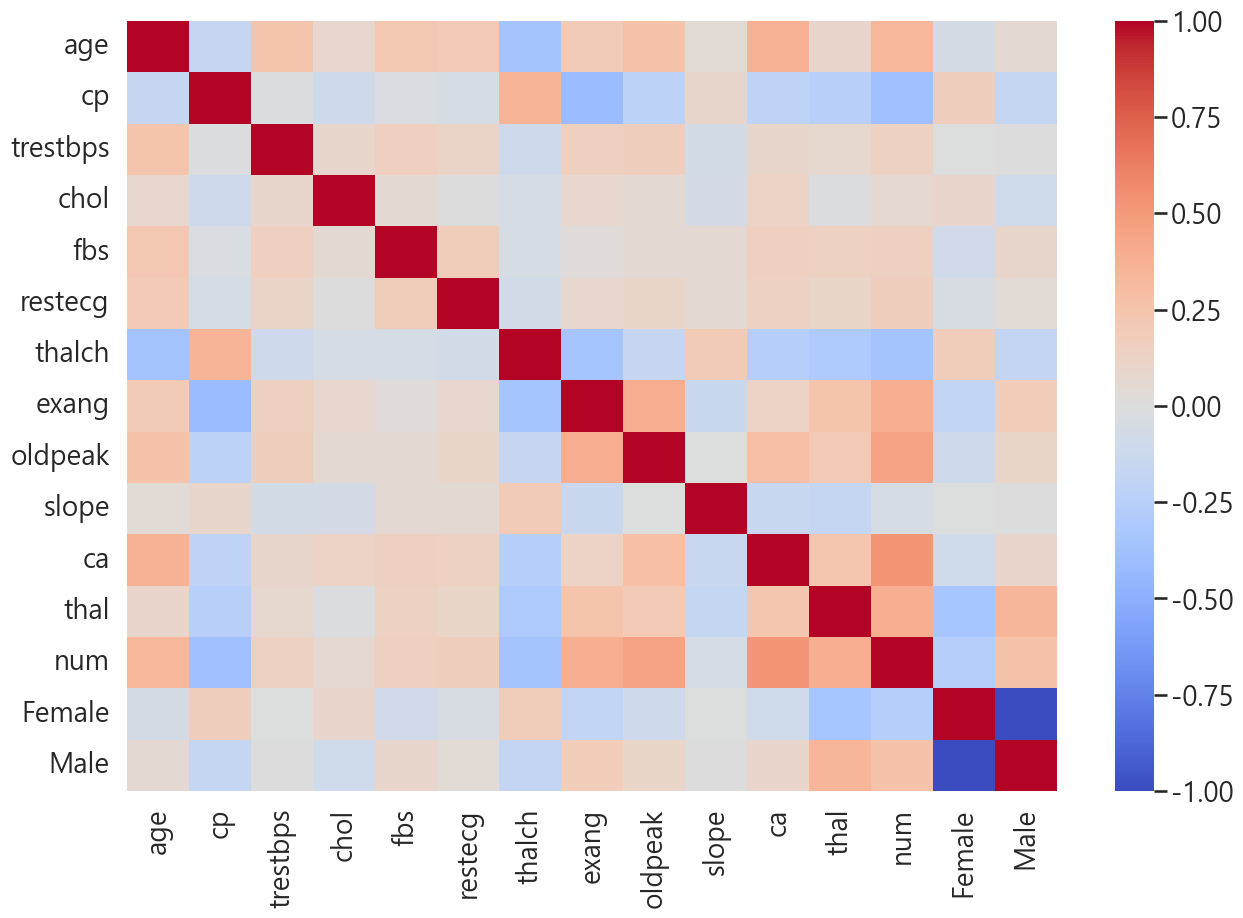

In [26]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), cmap = "coolwarm")

In [27]:
df.corr()[df.corr() > 0.8].fillna('')

,age,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,Female,Male
age,1.0,,,,,,,,,,,,,,
cp,,1.0,,,,,,,,,,,,,
trestbps,,,1.0,,,,,,,,,,,,
chol,,,,1.0,,,,,,,,,,,
fbs,,,,,1.0,,,,,,,,,,
restecg,,,,,,1.0,,,,,,,,,
thalch,,,,,,,1.0,,,,,,,,
exang,,,,,,,,1.0,,,,,,,
oldpeak,,,,,,,,,1.0,,,,,,
slope,,,,,,,,,,1.0,,,,,


In [28]:
df[['exang','fbs']] = df[['exang','fbs']].astype('bool')

# Missing value          
---

In [29]:
df_null = df.isna().sum().reset_index()
df_nunique = df.nunique().reset_index()
df_dtypes = df.dtypes.reset_index()

df_info = pd.merge(df_null, df_nunique, on = "index", how = "left")
df_info = pd.merge(df_info, df_dtypes, on = 'index', how = "left")

df_info['null_ratio'] = round(df_info['0_x'] / len(df) * 100, 2).astype('str') + "%"
df_info = df_info.rename(columns = {"index":"col",'0_x':"null_count","0_y":"nunique_count",0:"dtypes"})
df_info = df_info[["col", "null_count", "null_ratio", "nunique_count", "dtypes"]]
print(f"Data\n\nIndex: {df.shape[0]}\nColumns: {df.shape[1]}")
df_info

Data

Index: 920
Columns: 15


,col,null_count,null_ratio,nunique_count,dtypes
0,age,0,0.0%,50,int64
1,cp,204,22.17%,3,float64
2,trestbps,60,6.52%,60,float64
3,chol,202,21.96%,216,float64
4,fbs,0,0.0%,2,bool
5,restecg,2,0.22%,3,float64
6,thalch,55,5.98%,119,float64
7,exang,0,0.0%,2,bool
8,oldpeak,64,6.96%,51,float64
9,slope,309,33.59%,3,float64


<Axes: >

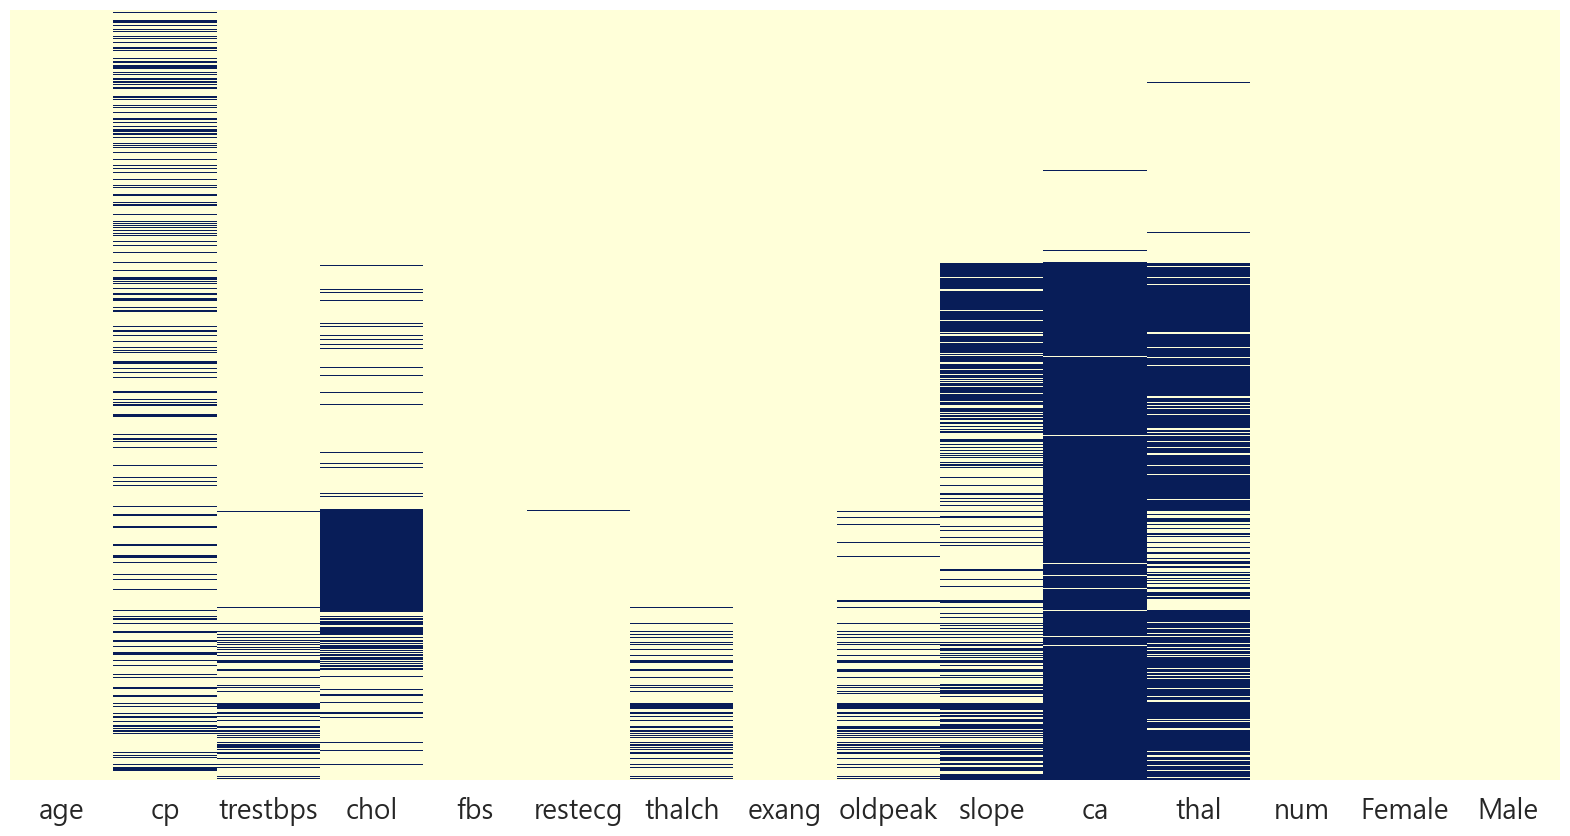

In [30]:
plt.figure(figsize = (20, 10))
sns.heatmap(data = df.isna(), yticklabels = False, cbar = False, cmap = 'YlGnBu')

In [31]:
isna_df_col = []
for col in df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False).index:
    isna_df_col.append(col)

isna_df_col

['ca',
 'thal',
 'slope',
 'cp',
 'chol',
 'oldpeak',
 'trestbps',
 'thalch',
 'restecg']

In [32]:
df[isna_df_col]

,ca,thal,slope,cp,chol,oldpeak,trestbps,thalch,restecg
0,0.0,2.0,2.0,2.0,233.0,2.3,145.0,150.0,1.0
1,3.0,0.0,0.0,0.0,286.0,1.5,160.0,108.0,1.0
2,2.0,1.0,0.0,0.0,229.0,2.6,120.0,129.0,1.0
3,0.0,0.0,2.0,NaN,250.0,3.5,130.0,187.0,0.0
4,0.0,0.0,1.0,1.0,204.0,1.4,130.0,172.0,1.0
...,...,...,...,...,...,...,...,...,...
915,NaN,NaN,NaN,0.0,333.0,0.0,127.0,154.0,2.0
916,NaN,NaN,NaN,2.0,139.0,NaN,NaN,NaN,2.0
917,NaN,2.0,NaN,0.0,223.0,0.0,122.0,100.0,2.0
918,NaN,NaN,NaN,0.0,385.0,NaN,NaN,NaN,1.0


In [33]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['ca', 'num', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
bool_cols = ['fbs', 'exang']

> iterative imputer (model = random forest)

In [34]:
df.thal.value_counts()

thal
0.0    196
1.0    192
2.0     46
Name: count, dtype: int64

In [35]:
for col in numeric_cols:
    imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=777), add_indicator=False)
    imputed_values = imputer.fit_transform(df[[col]])
    
    df[col] = imputed_values

In [36]:
for col in categorical_cols:    
    imputer = IterativeImputer(estimator=RandomForestClassifier(random_state=777), add_indicator=True)
    imputed_values = imputer.fit_transform(df[[col]])
    
    df[col] = imputed_values
    
    for col in bool_cols:
        df[col] = df[col].astype('bool')

In [37]:
df_null = df.isna().sum().reset_index()
df_nunique = df.nunique().reset_index()
df_dtypes = df.dtypes.reset_index()

df_info = pd.merge(df_null, df_nunique, on = "index", how = "left")
df_info = pd.merge(df_info, df_dtypes, on = 'index', how = "left")

df_info['null_ratio'] = round(df_info['0_x'] / len(df) * 100, 2).astype('str') + "%"
df_info = df_info.rename(columns = {"index":"col",'0_x':"null_count","0_y":"nunique_count",0:"dtypes"})
df_info = df_info[["col", "null_count", "null_ratio", "nunique_count", "dtypes"]]
print(f"Data\n\nIndex: {df.shape[0]}\nColumns: {df.shape[1]}")
df_info

Data

Index: 920
Columns: 15


,col,null_count,null_ratio,nunique_count,dtypes
0,age,0,0.0%,50,float64
1,cp,0,0.0%,4,float64
2,trestbps,0,0.0%,61,float64
3,chol,0,0.0%,217,float64
4,fbs,0,0.0%,2,bool
5,restecg,0,0.0%,4,float64
6,thalch,0,0.0%,120,float64
7,exang,0,0.0%,2,bool
8,oldpeak,0,0.0%,52,float64
9,slope,0,0.0%,4,float64


# Model              
---